In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [18]:
# Load the data
df = pd.read_excel("C:/Users/baner/Documents/Planet-Hunt/data/Study_of_exoplanets.xlsx")

# Data preprocessing
feature_columns = ['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 
                   'P_INCLINATION', 'P_ESCAPE', 'P_POTENTIAL'
                   ]  

target_column = 'P_HABITABLE'

# Data preprocessing
for col in feature_columns:
    df[col].fillna(df[col].median(), inplace=True)

df_cleaned = df[feature_columns + [target_column]]

# Display the cleaned DataFrame
print(df_cleaned.head())

       P_MASS  P_RADIUS    P_PERIOD  P_SEMI_MAJOR_AXIS  P_ECCENTRICITY  \
0  6165.86330   2.33168   326.03000               1.29           0.231   
1  4684.78480   2.33168   516.21997               1.53           0.080   
2  1525.57440   2.33168   185.84000               0.83           0.000   
3  1481.07850   2.33168  1773.40000               2.93           0.370   
4   565.73385   2.33168   798.50000               1.66           0.680   

   P_INCLINATION  P_ESCAPE  P_POTENTIAL  P_HABITABLE  
0           88.1  3.876993    15.031085            0  
1           88.1  3.876993    15.031085            0  
2           88.1  3.876993    15.031085            0  
3           88.1  3.876993    15.031085            0  
4           88.1  3.876993    15.031085            0  


C:\Users\baner\AppData\Local\Temp\ipykernel_8048\1744539839.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\baner\AppData\Local\Temp\ipykernel_8048\1744539839.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [19]:
# Features and target variable
X = df_cleaned[['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 
          'P_INCLINATION', 'P_ESCAPE', 'P_POTENTIAL'
          ]]
          
y = df_cleaned['P_HABITABLE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# DL model
model = keras.Sequential([
    # Input layer
    keras.layers.InputLayer(input_shape=(X_train_resampled.shape[1],)),

    # Hidden layers
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    
    # Output layer
    keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


# Train the model
history = model.fit(X_train_resampled, y_train_resampled, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50


c:\Users\baner\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6044 - loss: 0.8470 - val_accuracy: 0.0730 - val_loss: 1.3935
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7872 - loss: 0.5306 - val_accuracy: 0.3490 - val_loss: 0.9510
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8155 - loss: 0.4518 - val_accuracy: 0.3161 - val_loss: 0.9370
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8276 - loss: 0.4080 - val_accuracy: 0.5430 - val_loss: 0.6928
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8397 - loss: 0.3608 - val_accuracy: 0.7861 - val_loss: 0.4765
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8532 - loss: 0.3467 - val_accuracy: 0.8206 - val_loss: 0.4753
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8592 - loss: 0.3267 - val_accuracy: 0.7105 - val_loss: 0.5429
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8666 - loss: 0.3095 - val_accuracy: 0.8873 - val_

In [20]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9451 - loss: 0.1506 
Test accuracy: 0.9395


In [21]:
# Generate a classification report
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
print(classification_report(y_test, y_pred, target_names=['Uninhabitable', 'Conservatively Habitable', 'Optimistically Habitable']))

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                          precision    recall  f1-score   support

           Uninhabitable       0.99      0.95      0.97       799
Conservatively Habitable       0.12      0.75      0.21         4
Optimistically Habitable       0.08      0.29      0.12         7

                accuracy                           0.94       810
               macro avg       0.40      0.66      0.43       810
            weighted avg       0.98      0.94      0.96       810



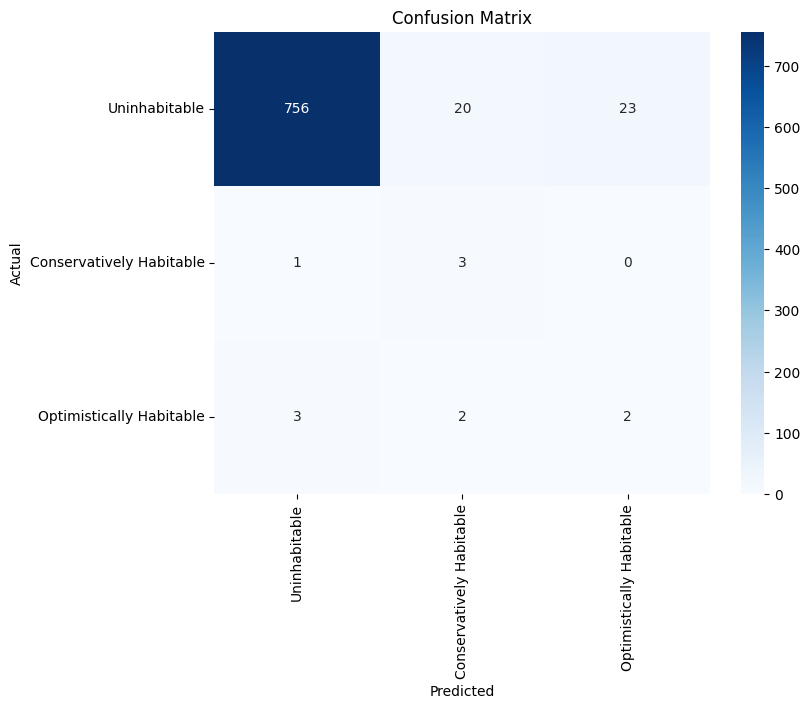

In [22]:
# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninhabitable', 'Conservatively Habitable', 'Optimistically Habitable'], 
            yticklabels=['Uninhabitable', 'Conservatively Habitable', 'Optimistically Habitable'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

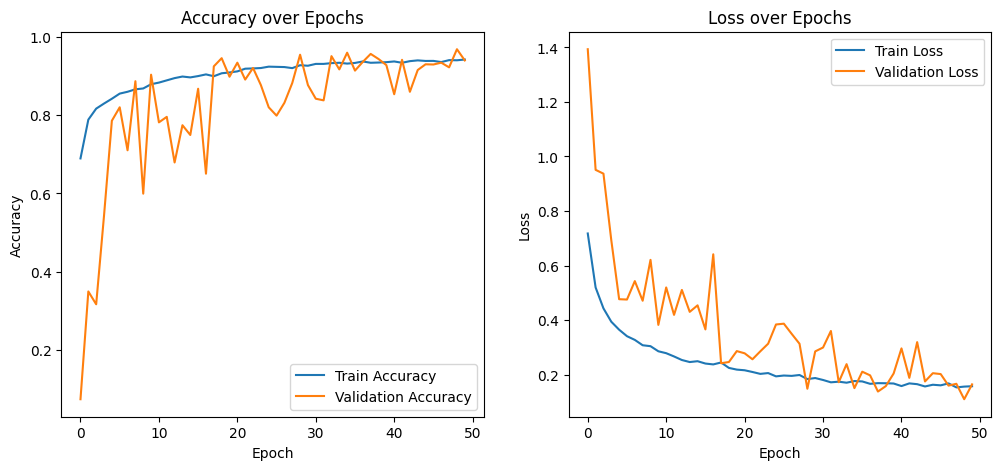

['scaler.pkl']

In [23]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the model
model.save('trained_model.h5')

import joblib
joblib.dump(scaler, 'scaler.pkl')

In [24]:
y.value_counts()

P_HABITABLE
0    3993
2      34
1      21
Name: count, dtype: int64